<img src = "https://drive.google.com/uc?export=view&id=102yRp1NqZJ12212QaersRTNL5_ZxieKX" alt = "Encabezado MLDS" width = "100%">  </img>

# **Aprendizaje no supervisado: agrupamiento**
---

Los métodos discutidos hasta ahora dependen de datos etiquetados para generar sus predicciones. El **aprendizaje no supervisado** es una tarea en donde se busca aprender propiedades o patrones de un conjunto de datos sin un objetivo sobre el cuál validar si la tarea se realizó de la manera adecuada. Estos grupos de objetos se deben crear de tal forma en que los objetos del mismo grupo sean similares entre sí y sean diferentes a los objetos de otros grupos.

En este material se discutirá el agrupamiento o *clustering*, una tarea no supervisada en donde se busca distinguir y agrupar objetos físicos o abstractos en clases de objetos **similares**. Algunos ejemplos de tareas o aplicaciones de *clustering* son:

- Distinguir taxonomías en biología con agrupaciones por similitud biológica o incluso genética.
- Identificar páginas web similares para estructurar resultados de búsquedas
- Segmentación de clientes o usuarios por un criterio de similitud definido.



El *clustering* es una tarea **no supervisada**, pues no sabemos _a priori_ cómo clasificar nuestros objetos, y **no completamente definida**, pues se plantean las preguntas:

- ¿Cómo cuantificamos el ***desempeño*** de un resultado de *clustering*?
- ¿Qué definición de ***similitud*** establecemos?
  

# **1. Dependencias**
---
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en algunos ejemplos.


### **1.1. Dependencias**
---
Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería _Scikit-learn_ (**`sklearn`**) y varias de sus funciones y conjuntos de datos.

In [1]:
#!pip install --upgrade matplotlib seaborn

In [2]:
# Actualizamos scikit-learn a la última versión
#!pip install -U scikit-learn

# Importamos scikit-learn
import sklearn

Importamos además algunas librerías básicas y configuraciones de *Python*.

In [3]:
# Librerías básicas NumPy, Pandas, Matplotlib y Seaborn.
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
# Configuraciones para las librerías y módulos usados.

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)
sns.set_theme()

### **1.2. Funciones de utilidad y visualización**
---

Para ilustrar los ejemplos discutidos en este material utilizaremos algunas funciones que permiten visualizar de manera general los datos, junto a las funciones de predicción obtenidas con cada modelo.

> **Nota**: *Matplotlib* y *Seaborn* se encuentran por fuera del alcance de este módulo. No es necesario que entienda estas funciones en detalle para sacar partido del resto del contenido puesto a su disposición. Usted decide si leer o no estas funciones en profundidad. Si decide omitir esta sección, continúe directamente con la siguiente sección, en donde se discutirán los conjuntos de datos que vamos a utilizar.

In [5]:
# Visualizar el resultado del agrupamiento con el algoritmo K-means para 8 valores de k.

from google.colab import widgets

def experiment_number_of_clusters(X, clustering, show_metric=None,
                                  plot_data=True, plot_centers=True, plot_boundaries=False):

    tb = widgets.TabBar([f'k = {k}'for k in range(2,10)])
    for i, n_clusters in enumerate(range(2,10)):
        with tb.output_to(i, select= (i < 1)):
          clustering.n_clusters = n_clusters
          y = clustering.fit_predict(X)

          cm = 'tab10'
          fig, ax = plt.subplots(figsize=(8, 6))
          plot_cluster_predictions(clustering, X, n_clusters, cm,
                                  plot_data, plot_centers, show_metric, ax = ax)

ModuleNotFoundError: No module named 'google.colab'

In [6]:
# Visualizar el resultado del agrupamiento con el algoritmo AgglomerativeClustering  para 8 valores de k.

from google.colab import widgets

def experiment_hyerarchical(X, show_metric=None,
                                  plot_data=True, plot_centers=True):

    tb = widgets.TabBar([f'KN = {k}'for k in [1, 2, 3, 90]])
    for i, kn in enumerate([1, 2, 3, 90]):
        with tb.output_to(i, select= (i < 1)):
          knn_graph = kneighbors_graph(X, kn, include_self=False)

          cm = 'tab10'
          fig, ax = plt.subplots(figsize=(8, 6))
          plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X,
                              n_clusters=2, show_metric='silueta', ax = ax)


ModuleNotFoundError: No module named 'google.colab'

In [7]:
# Gráfica individual del resultado de un agrupamiento.
from sklearn.metrics import silhouette_score

def plot_cluster_predictions(clustering, X, n_clusters = None, cmap = 'tab10',
                             plot_data=True, plot_centers=True, show_metric=None,
                             title_str="", ax = None):

    assert not hasattr(clustering, "n_clusters") or \
           (hasattr(clustering, "n_clusters") and n_clusters is not None), "must specify `n_clusters` for "+str(clustering)

    if n_clusters is not None:
        clustering.n_clusters = n_clusters

    y = clustering.fit_predict(X)
    # remove elements tagged as noise (cluster nb<0)
    X = X[y>=0]
    y = y[y>=0]

    if n_clusters is None:
        n_clusters = len(np.unique(y))

    if ax is None:
        ax = plt.gca()

    if plot_data:
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette=cmap,
                            legend=False, alpha=.5, ax=ax, s=40)

    if plot_centers and hasattr(clustering, "cluster_centers_"):
        sns.scatterplot(x=clustering.cluster_centers_[:,0],
                    y=clustering.cluster_centers_[:,1], hue = np.unique(y), s=180,  lw=3,
                    palette=cmap,
                    edgecolor="black", legend = False, ax = ax)

    if show_metric is not None:
        if show_metric == 'inercia' and hasattr(clustering, 'inertia_'):
          inertia = clustering.inertia_
          ax.set_title("Inercia = {:.0f}".format(inertia)+ title_str, fontdict=dict(family = 'serif', size = 20))
        elif show_metric == 'silueta':
          sc = silhouette_score(X, y) if len(np.unique(y)) > 1 else 0
          ax.set_title("Coeficiente de silueta = {:.3f}".format(sc)+ title_str, fontdict=dict(family = 'serif', size = 20))
    else:
        ax.set_title("k={}".format(n_clusters) +title_str, fontdict=dict(family = 'serif', size = 20))

    plt.axis("off")

    return

In [8]:
# Gracicar la curva de aprendizaje de determinada métrica de agrupamiento.

def plot_metric(K, scores, metric_name):
  plt.figure(dpi=110, figsize=(9, 5))
  plt.plot(K, scores, 'bx-')
  plt.xticks(K); plt.xlabel('$k$', fontdict=dict(family = 'serif', size = 14));  plt.ylabel(metric_name, fontdict=dict(family = 'serif', size = 14));
  plt.title(f'K vs {metric_name}', fontdict=dict(family = 'serif', size = 18))
  plt.show()

# **2. Conjuntos de datos**
---

Para los ejemplos desarrollados en el transcurso de material, se usarán datos de  *Scikit-Learn* de carácter real (usando *Loaders*) y sintético (usando *Generators*).

Usaremos el *dataset* *Iris* para mostrar un ejemplo de evaluación externa, el *dataset* [Titanic](https://www.kaggle.com/c/titanic) para mostrar un ejemplo de aplicación y finalmente usaremos un conjunto de datos artificial que cargaremos desde una URL remota.

Cargamos *Iris* usando el módulo **`sklearn.datasets`**.

In [9]:
from sklearn.datasets import load_iris
iris = load_iris()

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Cargamos el *dataset* *Titanic* desde una Google drive remoto con *gdown*:

In [10]:
# Id remoto del conjunto de datos Titanic.
!gdown --id 19ciOuzzyxN-Ht03lBwHAqEyrsmWBUhDK
titanic_df = pd.read_csv('titanic.csv')

titanic_df

C:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19ciOuzzyxN-Ht03lBwHAqEyrsmWBUhDK
To: D:\Proyectos\UNAL\Curso 2\Sesion 4\Material\titanic.csv

  0%|          | 0.00/60.3k [00:00<?, ?B/s]
100%|##########| 60.3k/60.3k [00:00<00:00, 1.29MB/s]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Retomaremos los conjuntos de datos de medias lunas y de *blobs* de *Scikit-Learn*:

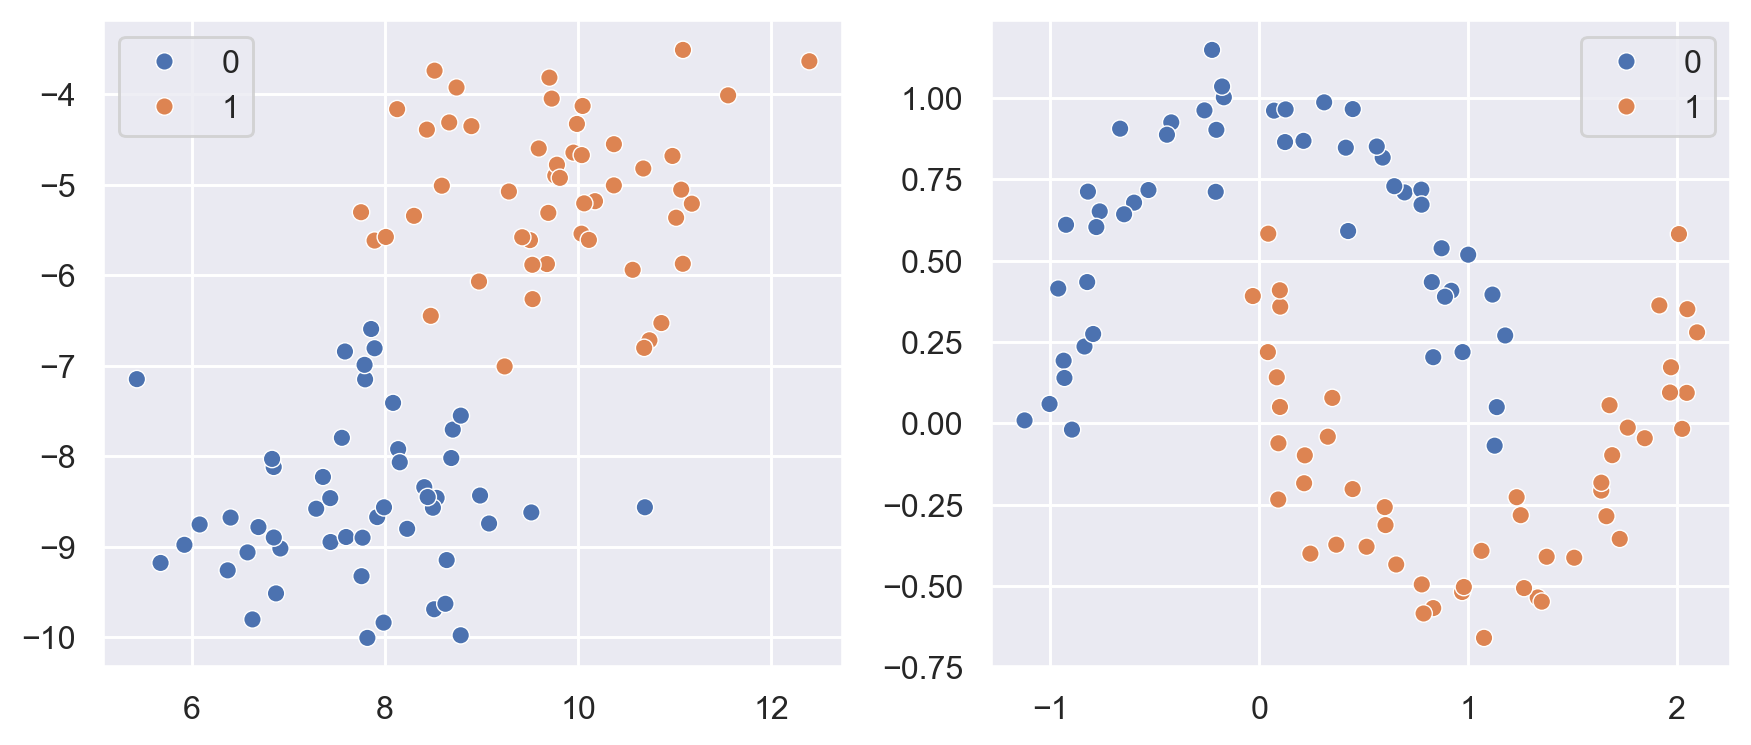

In [11]:
from sklearn.datasets import make_blobs, make_moons

X_blobs, y_blobs = make_blobs(centers = 2, random_state= 321)
X_moons, y_moons = make_moons(noise = 0.1, random_state= 123)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))

sns.scatterplot(x = X_blobs[:, 0], y = X_blobs[:, 1], hue = y_blobs, ax = ax1);
sns.scatterplot(x = X_moons[:, 0], y = X_moons[:, 1], hue = y_moons, ax = ax2);

Cargamos el conjunto de datos artificial usando *Pandas*.

In [12]:
url = 'https://gist.githubusercontent.com/fagonzalezo/d4c3992ba89f7598a75adc5290531451/raw/de2edd17e526a96ff9e063c9014f7e0c4a06e922/cluster1.csv'
cluster_df = pd.read_csv(url)
X_cluster = cluster_df.values

X_cluster.shape

(500, 2)

# **3. Métodos basados en centroides - `KMeans`**
---
> **¿Qué grupos identifica en la siguiente gráfica y cómo se puede automatizar el proceso?**

Los humanos poseen la capacidad de inferir rápidamente grupos gracias a su intuición y poderoso sistema visual. Sin embargo, para conjuntos de datos más complejos se tienen que plantear técnicas para que un computador pueda resolver este tipo de problemas de manera automática.

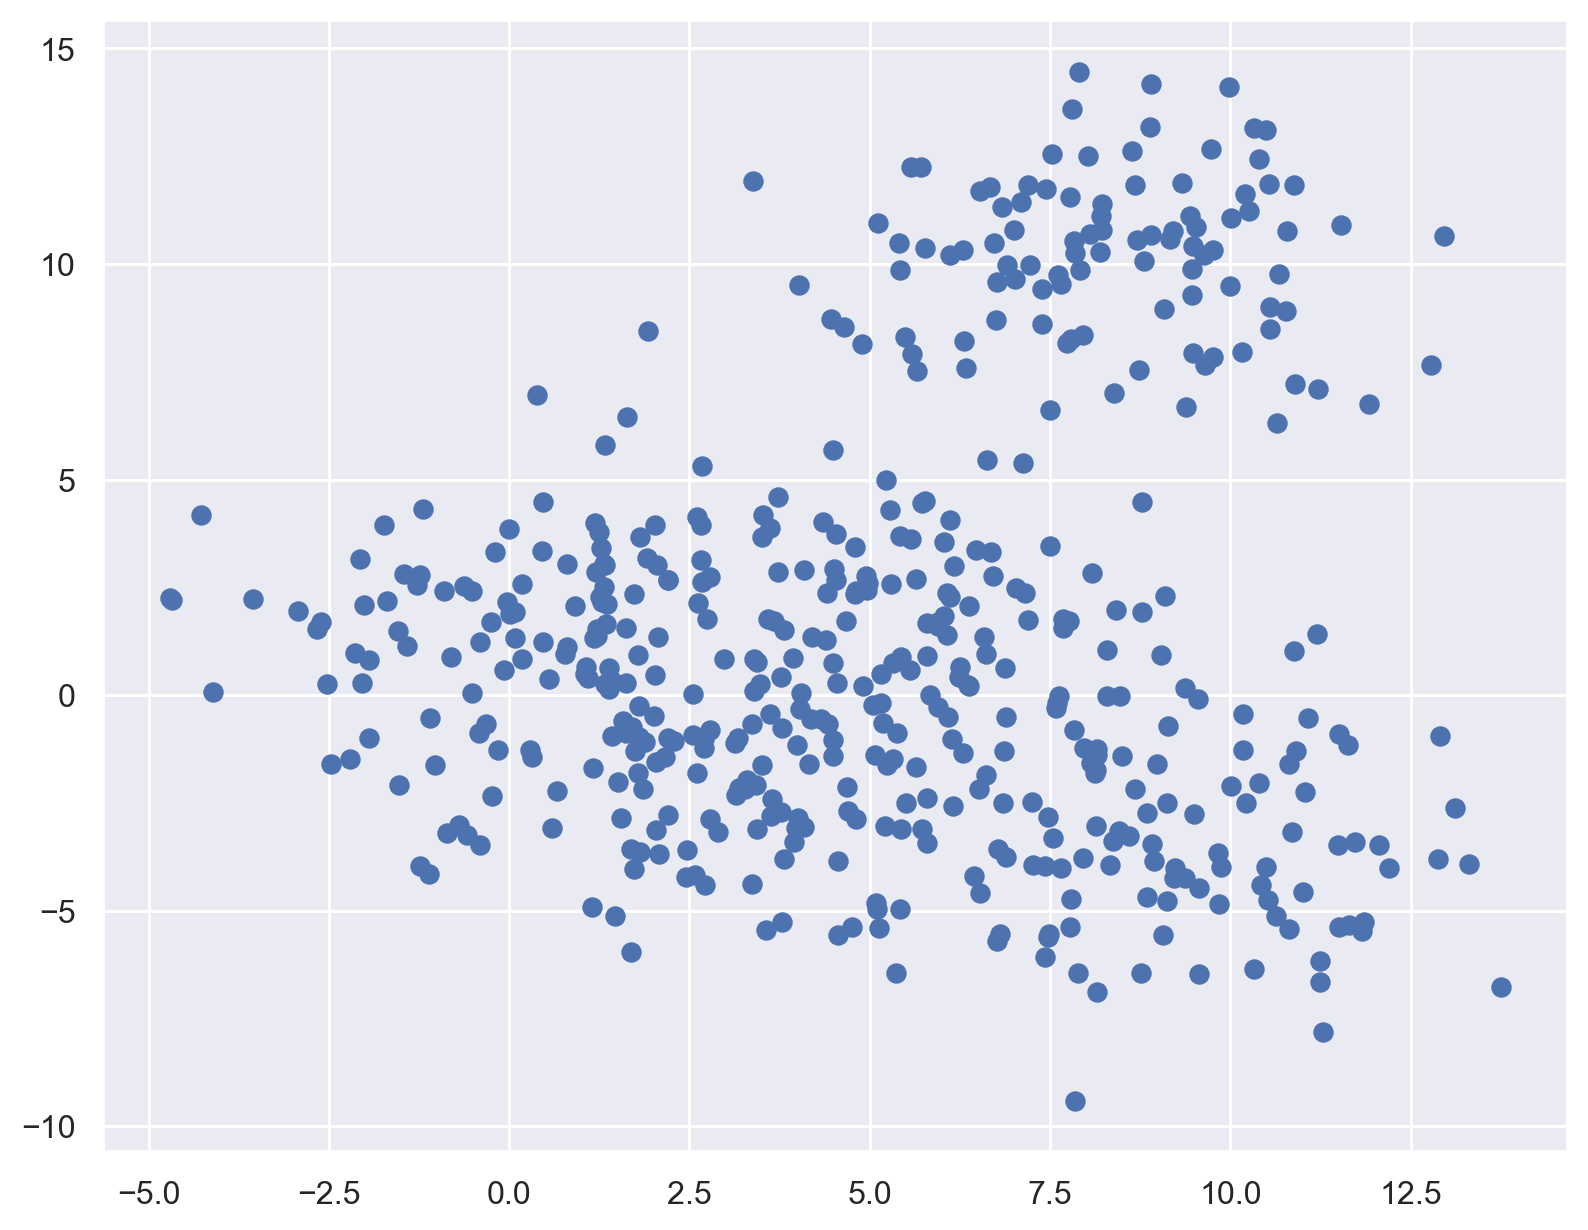

In [13]:
url = 'https://gist.githubusercontent.com/fagonzalezo/d4c3992ba89f7598a75adc5290531451/raw/de2edd17e526a96ff9e063c9014f7e0c4a06e922/cluster1.csv'
cluster_df = pd.read_csv(url)
X_cluster = cluster_df.values

plt.scatter(X_cluster[:,0],
            X_cluster[:,1]);

El **algoritmo *k-means*** (o *k-medias*), es un método de agrupamiento que supone que los grupos (*clusters*) están representadas por un prototipo o elemento representativo, que corresponde al centroide del conjunto de datos. Es un algoritmo iterativo que en cada iteración asigna los elementos al centroide más cercano y recalcula los centroides de acuerdo con los nuevos elementos asignados a cada grupo.

La idea general del algoritmo se puede ver en forma de *pseudo-código*:
```
Entrada:
    X: Datos a agrupar.
    k: Número de clusters deseados.
    
Algoritmo:
    1. Se seleccionan k centroides aleatoriamente.
    2. Se repite hasta que los k centroides no cambien:
    3.    Se establecen k clusters asignando cada dato al centroide más cercano.
    4.    Se recalcula el centroide de cada cluster como el promedio (mean) de los datos.
```

En los siguientes videos podrá ver de manera gráfica el concepto del algoritmo aplicado:

In [14]:
#@markdown **Animación: Algoritmo *K-means***

from IPython.display import HTML

HTML('<iframe style="width:768px; height: 432px;" src="https://drive.google.com/file/d/1YwiKTNqoHNtovepfS8aGZyF25M0KMMCN/preview"></iframe>')

In [15]:
#@markdown **Video: Ejemplo de agrupamiento con *K-means***

from IPython.display import HTML
HTML('<iframe width="758" height="432" src="https://www.youtube.com/embed/BVFG7fd1H30" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')


Podemos usar el método de *Scikit-Learn* **`sklearn.cluster.KMeans`** para ejecutar este algoritmo en nuestros datos. El siguiente código aplica el algoritmo *k-means* al conjunto de datos artificial. Puesto que es un modelo no supervisado, la función **`fit`** solo recibe como argumento los datos de entrada, no las etiquetas. La función **`predict`** asigna *clusters* a los ejemplos, y se usa tanto en los datos de entrenamiento como en ejemplos nuevos.

In [16]:
# Métodos de agrupamiento - Algoritmo K-means
from sklearn.cluster import KMeans

# Número de clusters que se desea generar.
n = 2

km = KMeans(n_clusters = n)
km.fit(X_cluster)

y = km.predict(X_cluster)

Usamos **`pandas`** para contar el número de elementos en cada cluster:

In [17]:
pd.Series(y).value_counts()

1    392
0    108
Name: count, dtype: int64

Las coordenadas de los centroides se pueden obtener con el atributo **`cluster_centers_`**:

El siguiente código dibuja los datos agrupados junto con los centroides:

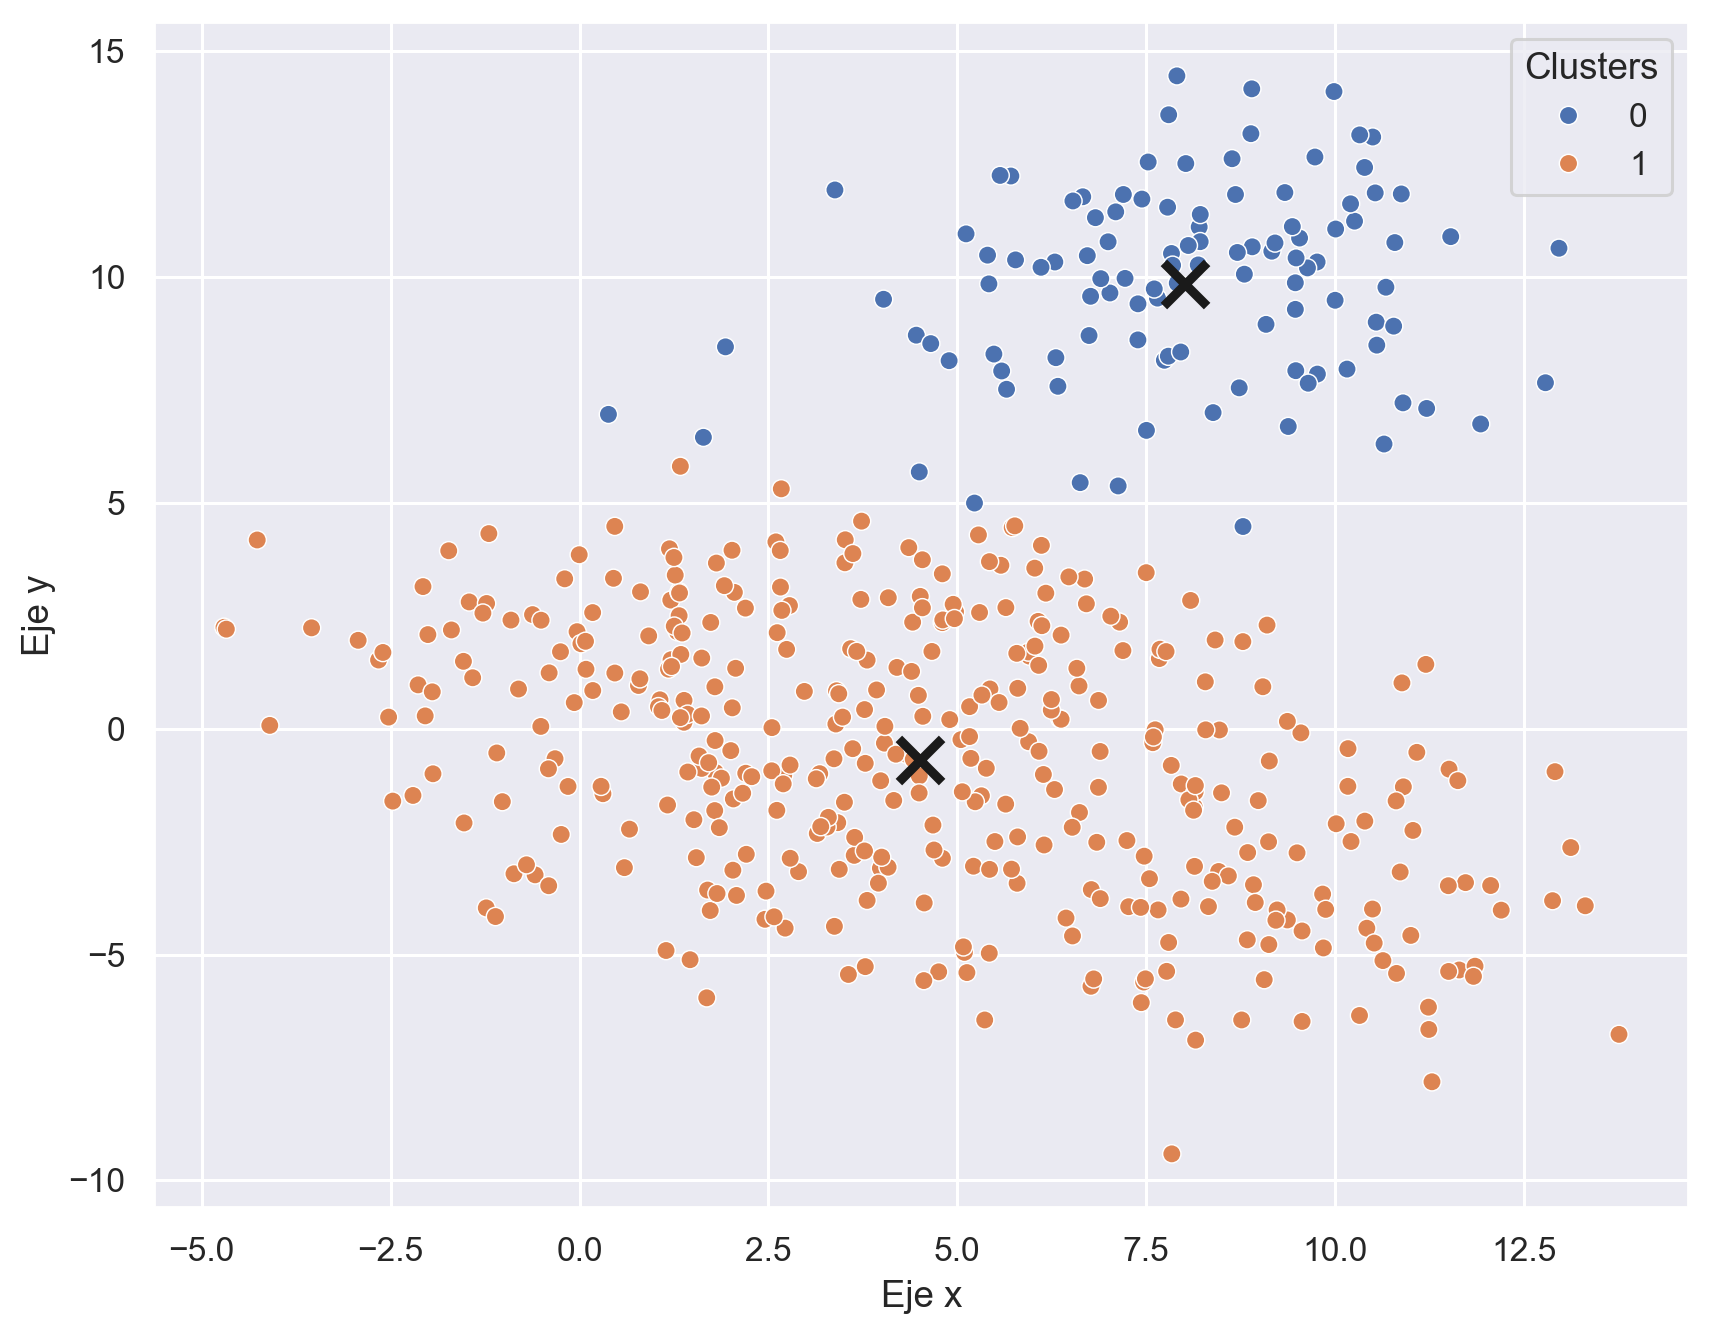

In [18]:
plt.figure(dpi = 110)
sns.scatterplot(x = X_cluster[:,0], y = X_cluster[:,1], hue = y)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],
            marker="x", lw=3, s=200, color = 'k')

plt.legend(title = 'Clusters'); plt.xlabel("Eje x"); plt.ylabel("Eje y");

Podemos ver los parámetros usados por el modelo con **`.get_params()`**.

In [21]:
km.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

La función **`experiment_number_of_clusters`** (definida al principio del notebook) muestra resultados con diferente número de *clusters*:

In [22]:
experiment_number_of_clusters(X_cluster, KMeans())

NameError: name 'experiment_number_of_clusters' is not defined

Ahora veamos el resultado al aplicar el algoritmo en otros conjuntos de datos sintéticos como **`make_blobs`**.
Cambie **`cluster_std`** y **`centers`** en **`make_blobs`** para generar *datasets* con distintas distribuciones.

**¿Cuál es el número de clusters _natural_ que usarías? ¿por qué es _natural_?**

In [23]:
# Conjunto de datos blobs.
from sklearn.datasets import make_blobs

X,_ = make_blobs(500, cluster_std=1.5, centers=3)

experiment_number_of_clusters(X, KMeans())

NameError: name 'experiment_number_of_clusters' is not defined

## **3.1. Selección del número de *clusters***
---

Si bien para un humano es intuitivo, para conjuntos de datos más grandes, con más dimensiones y para hacerlo de manera automática necesitamos usar otros criterios. Para esto necesitamos usar una medida objetiva de la calidad de un *clustering*. Estas medidas se encuentran definidas en el paquete [**`sklearn.metrics.cluster`**](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics). Algunas medidas son supervisadas y otras no-supervisadas:
*  **Medidas supervisadas**: Utilizan las etiquetas reales de los ejemplos para analizar la correspondencia entre *clusters* y clases.
* **Medidas no-supervisadas**: Calculan medidas basadas en las distancias intra-cluster y/o inter-cluster.

En este material se discutirán las medidas no-supervisadas, partiendo del hecho en que en este tipo de tareas no siempre es posible contar con la etiqueta real de los datos.

#### **3.1.1. Inercia o distancia intra-cluster**
---

La distancia **intra-cluster** mide qué tan compacto es cada *cluster* y se define como:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

*k-means* minimiza esta medida, lo cual la hace una buena candidata para evaluar la calidad de un *cluster*. Para esto ejecutamos *k-means* con diferentes valores de $k$ y graficamos el valor de la inercia. En esta gráfica buscamos un valor de $k$ tan pequeño como sea posible y que tenga un valor de la métrica bajo. A este tipo de gráfica se le conoce usualmente como **gráfica de codo**:

In [24]:
#@markdown **Video: Método del codo**

from IPython.display import HTML

HTML('<iframe style="width:768px; height: 432px;" src="https://drive.google.com/file/d/1cRPD6BX26wEWf0yTeYcTKsV5o5f6RRUQ/preview"></iframe>')

Para ilustrar este concepto, vamos a generar un modelo de agrupamiento para cada valor de $k$ entre $2$ y $15$. Al final de la generación, obtenemos el valor de la métrica de inercia con el atributo **`intertia_`**.

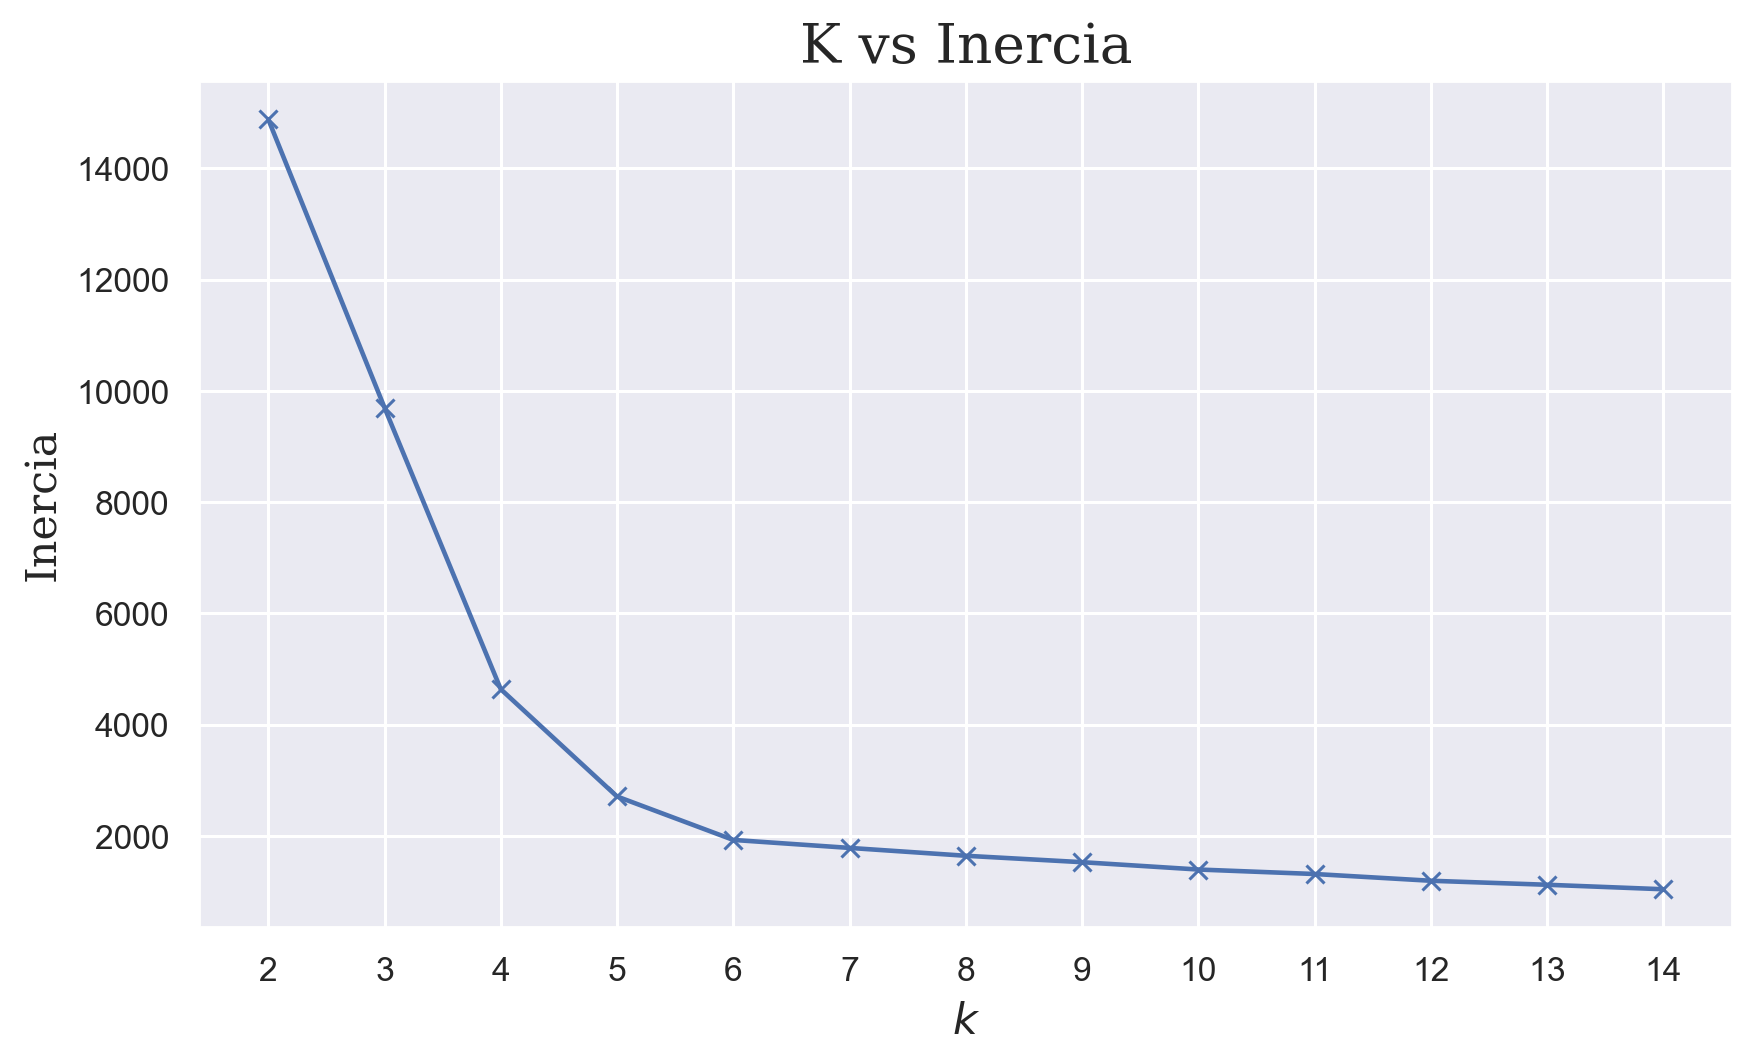

In [25]:
X,_ = make_blobs(500, cluster_std=1.5, centers=6, random_state=10)

sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

plot_metric(K, sum_of_squared_distances, 'Inercia')

In [26]:
experiment_number_of_clusters(X, KMeans(), show_metric='inercia')

NameError: name 'experiment_number_of_clusters' is not defined

Ahora aplicamos la misma estrategia para el conjunto de datos artificial:

In [ ]:
sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_cluster)
    sum_of_squared_distances.append(km.inertia_)

plot_metric(K, sum_of_squared_distances, 'Inercia')

In [ ]:
experiment_number_of_clusters(X_cluster, KMeans(), show_metric='inercia')

La gráfica de codo nos sugiere un valor de $k$ de 5 o 6. La razón es que hay un *cluster* mucho más grande que el otro. Esto evidencia algunos de los problemas que tiene la inercia o suma de distancia *intra-cluster*:
*  La inercia supone que los *clusters* son convexos e isotrópicos, lo que no siempre es así. Responde mal a los grupos alargados, o múltiples con formas irregulares.
* La inercia supone que los *clusters* son de tamaños similares, pues penaliza mucho más fuertemente *clusters* grandes.
* La inercia no es una métrica normalizada: solo sabemos que los valores más bajos son mejores y que el cero es el óptimo.



#### **3.1.2. Coeficiente de silueta**
---

El coeficiente de silueta combina la distancia media *intra-cluster* ($a$) y la distancia media al grupo más cercano ($b$) para cada muestra ($s_i$):
$$ s_i = \frac{b - a}{\max(a,b)}$$

Es una medida que está entre $-1$ y $1$ para cada muestra. Un valor cercano a $1$ indica que la distancia inter-cluster es mucho más grande que la distancia intra-cluster. También indica que la muestra que estamos evaluando está en la frontera entre dos _clusters_.

> **Nota**: Tenga en cuenta que el coeficiente de silueta solo tiene sentido cuando $2<=k<=n$ con $k$ siendo el número de clusters y $n$ el tamaño de la muestra.

Para calcular el coeficiente de silueta del proceso de agrupamiento *sklearn* utiliza la media de cada valor de silueta $s_i$

In [ ]:
# Métricas de rendimiento
from sklearn.metrics import silhouette_score

X,_ = make_blobs(500, cluster_std=1.5, centers=6, random_state=10)
silhouette_scores = []

K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    y = km.predict(X)
    silhouette_scores.append(silhouette_score(X, y))

plot_metric(K, silhouette_scores, 'Coeficiente de silueta')

En contraste con el diagrama de inercia donde buscamos el codo de la gráfica, aquí buscamos el valor máximo. Que en este caso se obtiene en $k = 5$. Para el segundo conjunto de datos tenemos:

In [ ]:
X = X_cluster
silhouette_scores = []
K = range(2,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    y = km.predict(X)
    silhouette_scores.append(silhouette_score(X, y))

plot_metric(K, silhouette_scores, 'Coeficiente de silueta')

En este caso el coeficiente de silueta máximo se alcanza en $k = 2$, que se ajusta más a lo esperado intuitivamente.

#### **3.1.3. Evaluación externa**
---

En la evaluación externa se usan datos adicionales que no estaban disponibles durante el entrenamiento al algoritmo de agrupamiento. Por ejemplo, las categorías reales de los ejemplos. Este tipo de evaluación también se conoce como evaluación supervisada.

En este caso usaremos *Iris* y evaluaremos el desempeño de _K-means_ sobre _Iris_ para varios valores de $k$ con varias métricas externas.




In [ ]:
# Partición en pruebas y entrenamiento.
from sklearn.model_selection import train_test_split

iris = load_iris()
X_iris, y_iris = iris.data, iris.target

Definimos la función **`plot_scores`** para graficar una métrica supervisada para varios valores de $k$.

In [ ]:
def plot_extern_metric(X, y, metric, metric_name):
  scores = []
  for i in range(2,20):
    model = KMeans(n_clusters=i, random_state=32)
    model.fit(X)
    y_pred = model.predict(X)
    scores.append(metric(y, y_pred))

  plot_metric(range(2, 20), scores, metric_name)

##### **3.1.3.1. Homogeneidad**
---

Para calcular la homogeneidad del proceso de agrupamiento, cada grupo es asociado con la clase mayoritaria; luego, La métrica se evalúa contando el número de ejemplos clasificados correctamente y dividiendo por N _(Manning, Raghavan & Schütze, 2008)_.

En este caso está acotada entre $0$ y $1$. Un valor cercano a $1$ nos indicará que las muestras de un *cluster* dado pertenecen en su mayoría a una sola clase.

*Scikit-learn* implementa el método **`homogeneity_score`** en el paquete **`metrics`**.

Después de importar la métrica, la usamos con la función **`plot_scores`**.


In [ ]:
from sklearn.metrics import homogeneity_score

In [ ]:
plot_extern_metric(X_iris, y_iris, homogeneity_score, 'Homogeneidad')

Podemos ver que se tendría que aplicar un análisis como el método del codo para determinar el número óptimo de clusters. En este caso se puede observar que luego de $8$ clusters la medida de homogeneidad llega a un punto de codo invertido. En este caso valores de $k$ entre $7$ y $8$ serían correctos.

Debemos tener en cuenta que la homogeneidad no es una medida simétrica, y si cambiamos **`y_true`** con **`y_pred`**, la función dará el puntaje de
[completitud de los *clusters*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score).

##### **3.1.3.2. Información mutua**
---

La información mutua es una medida de la similitud entre dos etiquetas de los mismos datos. Es una métrica simétrica, si se cambian las posiciones de **`y_true`** y **`y_pred`** la métrica retorna el mismo valor. La información mutua tiene una importante interpretación en la teoría de la información. En términos de teoría de la información, esta medida nos da qué tanta información ganamos de una variable no observada al observar una variable relacionada.

*Scikit-Learn* implementa **`mutual_info_score`** en el paquete **`metrics`**.

Después de importar la métrica la usamos con la función **`plot_scores`**.


In [ ]:
from sklearn.metrics import mutual_info_score

In [ ]:
plot_extern_metric(X_iris, y_iris,
            mutual_info_score, 'Información mutua')

Podemos ver que se tendría que aplicar un análisis como el método del codo para determinar el número óptimo de clusters. En este caso podemos observar que el valor de cambio es $7$. En este caso la medida nos dice que al tener $7$ clusters, obtenemos casí el máximo información posible.

##### **3.1.3.3. Índice de Rand**
---
El **índice de *Rand*** computa una medida de similitud entre dos agrupamientos al considerar todas las parejas de ejemplos, contando el número de ejemplos que pertenecen al mismo grupo y los que no en el agrupamiento real y en el predicho.

*Scikit-learn* implementa **`adjusted_rand_score`** en el paquete **`metrics`**. Esta implementación es una versión corregida del índice de _Rand_ que tiene en cuenta el "*chance*", es decir la aleatoriedad de los agrupamientos. Agrupamientos aleatorios tienen un índice de _Rand_ ajustado cercanos a $0$, con $1$ siendo un agrupamiento perfecto.

Después de importar la métrica la usamos con la función **`plot_scores`**.

In [ ]:
from sklearn.metrics import adjusted_rand_score

plot_extern_metric(X_iris, y_iris,
            adjusted_rand_score, 'Índice de Rand ajustado')

Podemos ver que el índice de *Rand* es una métrica que buscamos máximizar, en este caso escogeríamos $k=3$.

##### **3.1.3.4. Matriz de Contingencia**
---

Una matriz de contingencia es una matriz similar a la matriz de confusión que muestra la relación entre las etiquetas asignadas para cada grupo y las etiquetas reales.

*Scikit-learn* implementa **`contigency_matrix`** en el paquete **`metrics.cluster`**.

Definimos la función **`show_contigency_matrix`** para entrenar un modelo **`KMeans`**, calcular la matriz de contigencia y retornarla como un objeto **`DataFrame`** de *Pandas*, lo que facilita su visualización.

In [ ]:
from sklearn.metrics.cluster import contingency_matrix

def show_contigency_matrix(X, y, n_clusters, classes):
  # Fijamos la semilla aleatoria para obtener resultados reproducibles.
  model = KMeans(n_clusters, random_state=32)
  model.fit(X)
  y_pred = model.predict(X)
  mat = contingency_matrix(y, y_pred)
  columns = ['Cluster ' + str(i) for i in range(n_clusters)]

  # Se retorna cómo un DataFrame de Pandas para mejorar la visualización.
  return pd.DataFrame(mat, columns=columns, index=classes)

Como hemos visto (y también de manera intuitiva), un valor de $k$ bueno es 3 o 4.

Ejecute las siguientes celdas para ver la matriz de contingencia para $k=3$ y $k=4$.

In [ ]:
show_contigency_matrix(X_iris, y_iris, 3, iris.target_names)

Podemos ver que el grupo $0$ corresponde a la especie _setosa_ (clase $0$), el grupo $1$ corresponde mayormente a la especie _virginica_ (clase $2$), y el grupo $2$ corresponde a la especie _versicolor_ principalmente (clase _1_).

El orden de los grupos y las clases no corresponden, esto tiene sentido, pues **`KMeans`** no tuvo acceso a las etiquetas durante el entrenamiento.

In [ ]:
show_contigency_matrix(X_iris, y_iris, 4, iris.target_names)

Si lo intentamos con un total de $4$ grupos, podemos ver que el grupo $0$ y el grupo $3$ corresponden a _versicolor_ (clase $1$), el grupo $1$ corresponde mayormente a la especie _setosa_ y el grupo $2$ corresponde principalmente a la especie _virginica_.

# **4. Métodos jerárquicos basados en conectividad - `AgglomerativeClustering`**
---
Para los dos *dataset* anteriores los resultados obtenidos son apropiados, aunque requieren de un buen uso de las métricas para obtener el número $k$ de *clusters* que se deben generar. Ahora, apliquemos el algoritmo en el *dataset* sintético de medias lunas con la función **`make_moons`**.



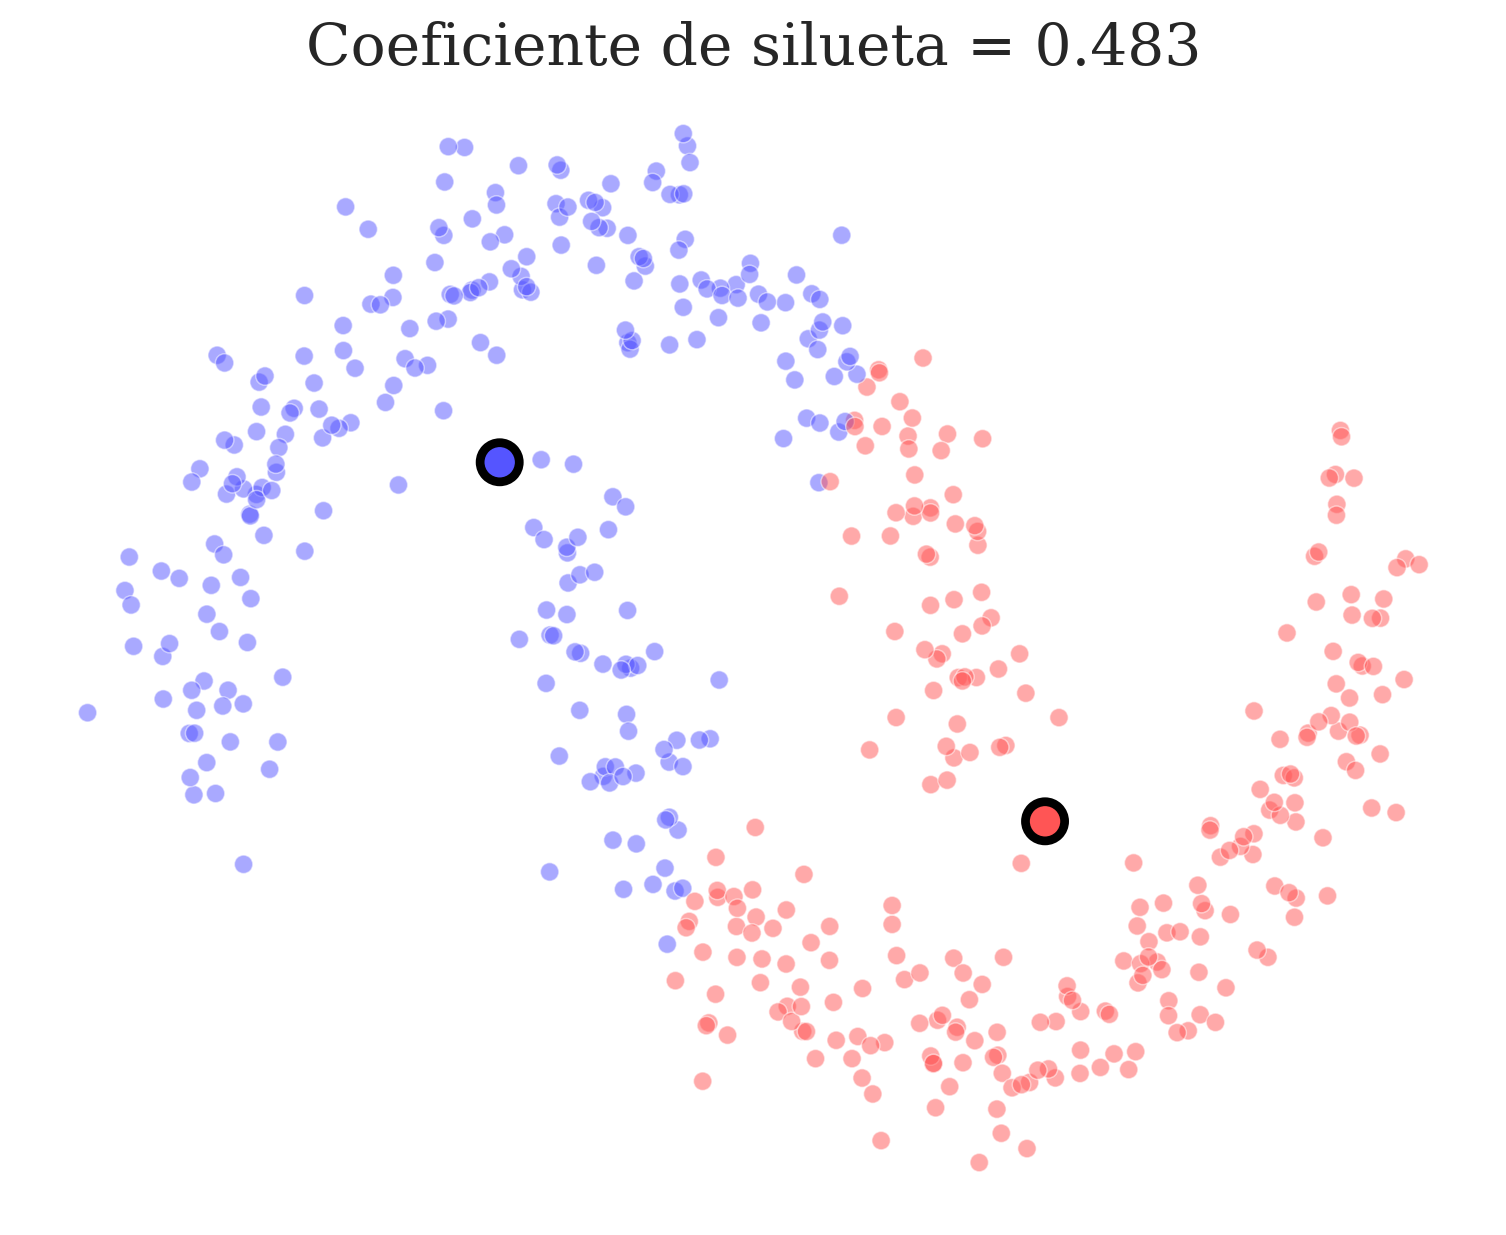

In [27]:
from sklearn.datasets import make_moons
X,_ = make_moons(500, noise=.1)

plot_cluster_predictions(KMeans(), X, n_clusters=2, cmap='seismic', show_metric='silueta')

Los grupos en este *dataset* no son convexos, por lo que *k-means* no es el mejor acercamiento al problema. Cuando los *clusters* no son globulares, otros métodos pueden producir mejores resultados.

Los métodos de agrupamiento **basados en conectividad** utilizan relaciones de vecindad entre los elementos para encontrar grupos. Estos métodos requieren construir una matriz de conectividad de los puntos. La función **`kneighbors_graph`** del paquete **`neighbors`** construye una matriz basada en los $k$ vecinos más cercanos de cada punto.

In [28]:
X, _ = make_moons(500, noise=.1)

Con la siguiente celda puede visualizar los K vecinos más cercanos de un punto seleccionado al azar.

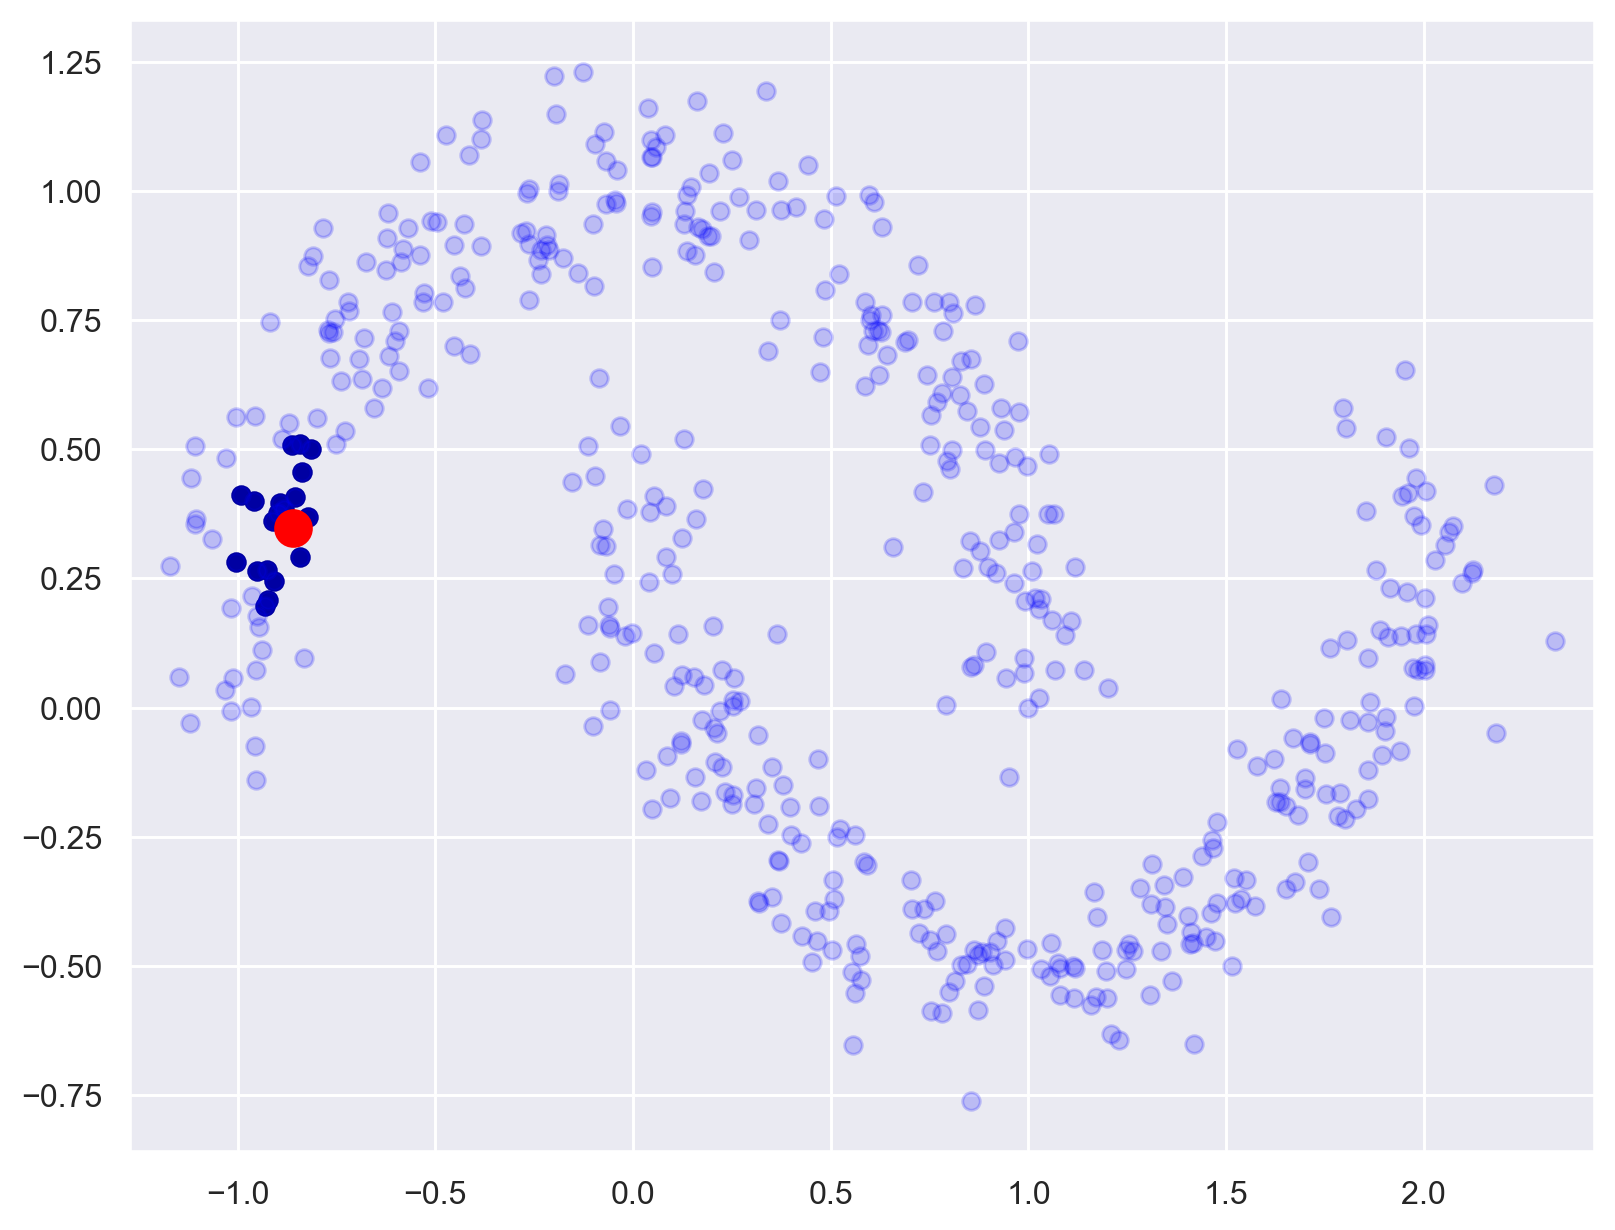

In [29]:
from sklearn.neighbors import kneighbors_graph

# Obtenemos el grafo de k- vecinos más cercanos por punto.
knn_graph = kneighbors_graph(X, 20, include_self=False)

# Obtenemos los n (20) vecinos más cercanos de un punto al azar
i = np.random.randint(len(X))
nn = X[knn_graph[i].toarray()[0].astype(bool)]

# Graficamos (en azul) 20 puntos más cercanos.
plt.scatter(nn[:,0], nn[:,1], color="darkblue", alpha=1)

# Graficamos el resto de punto con menos opacidad.
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.2)

# Graficamos (en rojo) el punto sobre el cual se evalúa la cercanía.
plt.scatter(X[i,0], X[i,1], s=150, color="red")

plt.xlim(np.min(X[:,0])-.1, np.max(X[:,0])+.1); plt.ylim(np.min(X[:,1])-.1, np.max(X[:,1])+.1);


Usamos esta matriz de conectividad para suministrar información de estructura al algoritmo. En este caso vamos a usar el algoritmo de *clustering* aglomerativo **`AgglomerativeClustering`**. Este recibe como argumento el grafo de conectividad (**`connectivity`**) y el criterio de enlazamiento entre grupos (**`linkage`**).

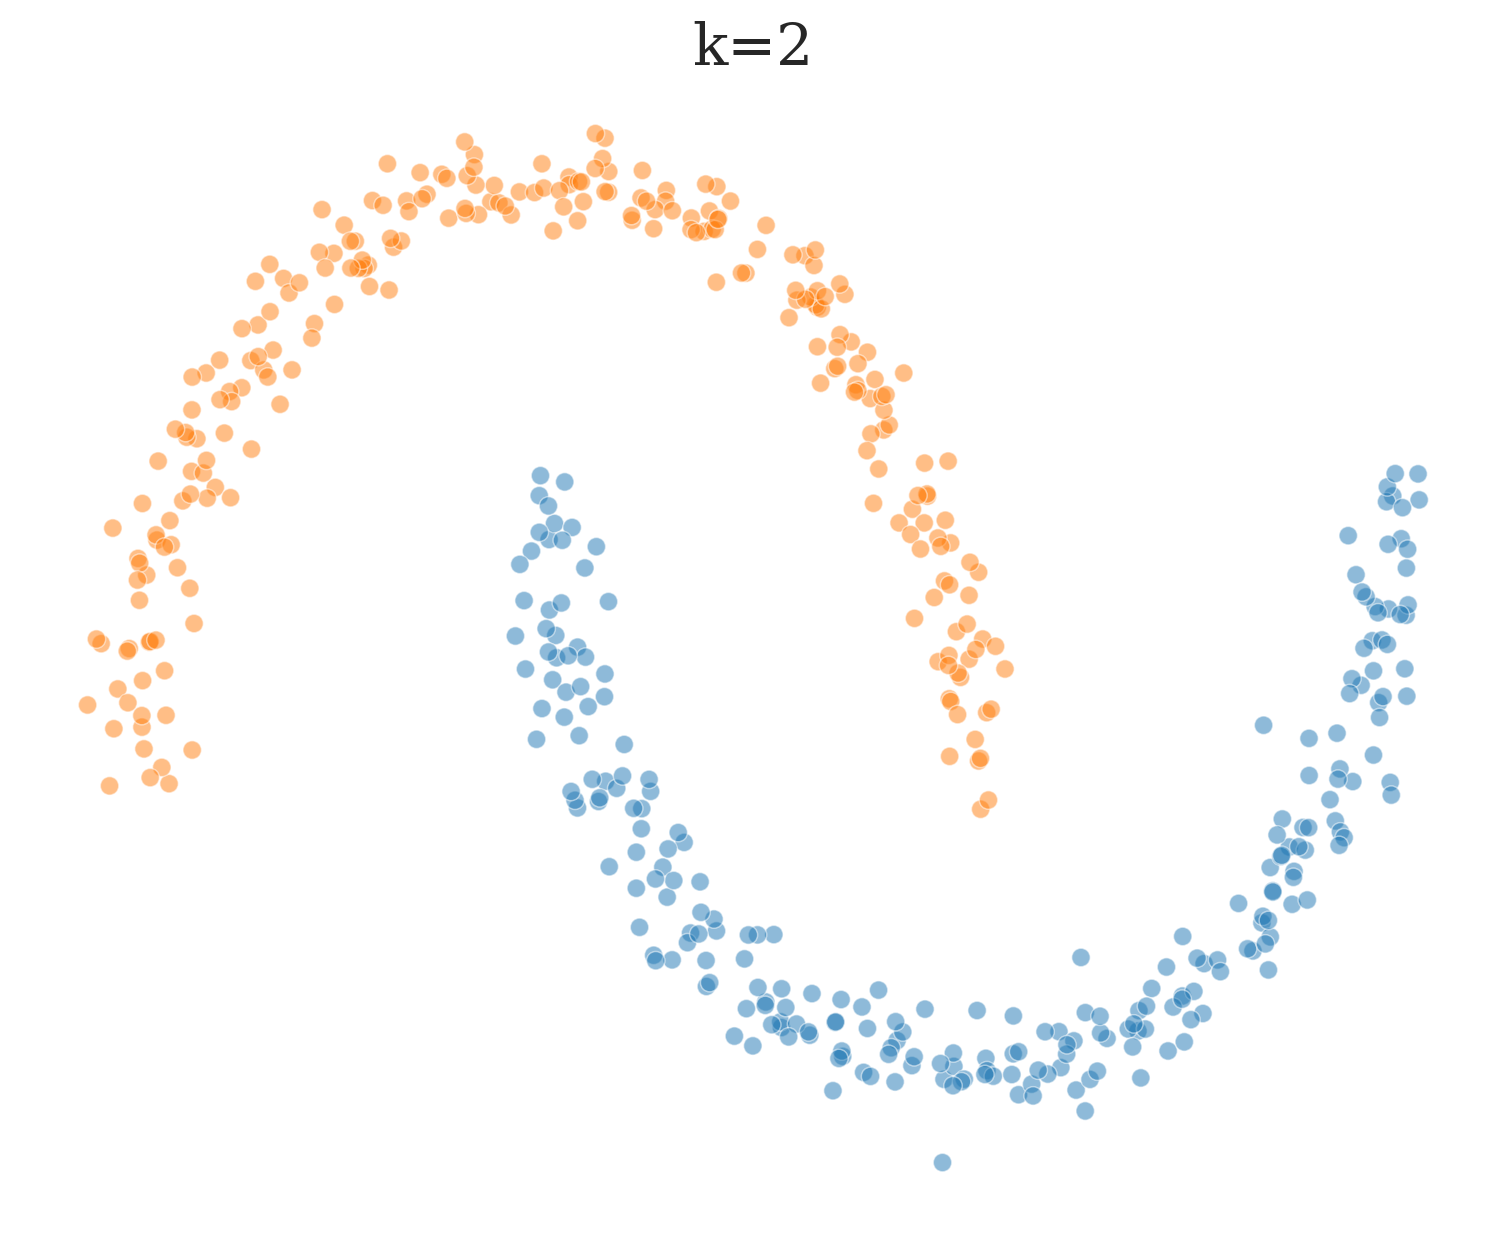

In [30]:
from sklearn.cluster import AgglomerativeClustering

X,_ = make_moons(500, noise=.05)
knn_graph = kneighbors_graph(X, 20, include_self=False)

# Declaramos el modelo
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")

plot_cluster_predictions(ac, X, n_clusters=2)

Cómo podemos ver, el método jerárquico se desempeña mucho mejor con las media lunas. El algoritmo **`AgglomerativeClustering`** realiza un agrupamiento jerárquico de la siguiente manera:

- Cada ejemplo empieza en su propio grupo, y los grupos son fusionados iterativamente.

- Los dos grupos que son fusionados en cada iteración dependen del criterio de enlazamiento, el cuál es definido por el parámetro **`linkage`**.

En este caso usamos el criterio de enlazamiento promedio (**`linkage = "average"`**). Este criterio minimiza el promedio de la distancia entre todos los ejemplos de cada par de grupos.

A continuación, podemos ver cómo los grupos encontrados por el algoritmo varía dependiendo del tamaño de la vecindad.

In [44]:
experiment_hyerarchical(X, show_metric='silueta')

NameError: name 'experiment_hyerarchical' is not defined

# **5. Ejemplo de aplicación: `Titanic`**
---

El 15 de abril de 1912, durante su viaje inaugural, el ampliamente considerado "insumergible" RMS Titanic se hundió después de chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, resultando en la muerte de 1502 de 2224 pasajeros y tripulación.

Aunque había un elemento de suerte en la supervivencia, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

Para finalizar este notebook se mostrará un ejemplo con el conjunto de datos [Titanic](https://www.kaggle.com/c/titanic), disponible en _Kaggle_.

Utilizando _Scikit-learn_ veremos un ejemplo del análisis de grupos y la supervivencia de estos. Este ejemplo incluye:

- Preprocesamiento (**`OneHotEncoder`**, **`StandardScaler`** y **`ColumnTransformer`**) .
- Agrupamiento con **`KMeans`**.
- Evaluación del desempeño externa e interna.
- Interpretación de los centroides.

## **5.1. Cargar el conjunto de datos**
---

Usando un *Id* público de google drive para cargar el conjunto de datos:

In [45]:
# Id remota del conjunto de datos Titanic.
!gdown --id 19ciOuzzyxN-Ht03lBwHAqEyrsmWBUhDK
titanic_df_raw  = pd.read_csv('titanic.csv')

C:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19ciOuzzyxN-Ht03lBwHAqEyrsmWBUhDK
To: D:\Proyectos\UNAL\Curso 2\Sesion 4\Material\titanic.csv

  0%|          | 0.00/60.3k [00:00<?, ?B/s]
100%|##########| 60.3k/60.3k [00:00<00:00, 601kB/s]
100%|##########| 60.3k/60.3k [00:00<00:00, 601kB/s]



El conjunto de Titanic cuenta con las siguientes características:

| Variable | Definición	| Valores |
| --- | --- | --- |
| survival | 	Supervivencia  | 	0 = No, 1 = Sí |
| pclass 	| Clase del tiquete | 	1 = 1ra, 2 = 2da, 3 = 3ra
| sex 	| Sexo 	| |
| Age |	Edad en años 	| |
| sibsp |	# de hermanos / cónyuge abordo del Titanic 	| |
| parch |	# de padres / hijos abordo del Titanic 	| |
| ticket |	Número del ticket | |
| fare 	| Costo del ticket | |
| cabin |	Número de la cabina 	| |
| embarked |	Puerto de embarque |	C = Cherbourg, Q = Queenstown, S = Southampton |

Veamos datos básicos del conjunto de datos con ayuda de **`info`**:

In [46]:
titanic_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


No utilizaremos todas las características de *Titanic*, y nos limitaremos al subconjunto de características:
```python
['Embarked', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Survived', 'Age']
```

Excluimos la característica **`Cabin`** por simplicidad, pues esta cuenta con muchos valores faltantes.

In [47]:
features = ['Embarked', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Survived', 'Age']
titanic_df = titanic_df_raw[features].dropna(axis=0)

# Visualizamos nuevamente la información del conjunto de datos resultante:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Embarked  712 non-null    object 
 1   Sex       712 non-null    object 
 2   Pclass    712 non-null    int64  
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Survived  712 non-null    int64  
 7   Age       712 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


Como podemos ver, **`Embarked`** y **`Sex`** son variables categóricas y el resto son numéricas. Esta información es necesaria para entender el ejemplo.

Antes de proceder con el preprocesamiento, convertimos los datos a la forma **`X, y`**.

Tenga en cuenta que en muchos casos no se cuenta con etiquetas en los ejercicios de agrupamiento. Es decir, no se cuenta con un **`X`** y con un **`y`**.  Sin embargo, en este ejemplo usaremos la variable **`'Survived'`** para evaluar el desempeño de los agrupamientos de manera externa.

Por esta razón no usaremos la variable **`Survived`** durante el entrenamiento, pero si en la evaluación.

In [48]:
X_titanic = titanic_df.drop(['Survived'], axis=1)
y_titanic = titanic_df.Survived

print(f'El shape de X_titanic es: {X_titanic.shape}')
print(f'El shape de y_titanic es: {y_titanic.shape}')

El shape de X_titanic es: (712, 7)
El shape de y_titanic es: (712,)


Observe que está vez no hemos convertido el *DataFrame* a un arreglo de *Numpy*, esto nos facilitará el preprocesamiento más adelante.

La principal ventaja de esto es que nos permite usar los nombres de las características. De igual manera, cómo veremos, no tendremos que preocuparnos por concatenar los datos transformados (unos categóricos y otros numéricos).

## **5.2. Preprocesamiento**
---

Para este ejemplo usaremos dos transformaciones conocidas: **`OneHotEncoder`** (para las características categóricas) y **`StandardScaler`** (para las características numéricas).

Con el fin de simplificar el código usaremos **`ColumnTransformer`**. El objeto **`ColumnTransformer`** es una utilidad que permite aplicar distintas transformaciones a distintas columnas de un *DataFrame* de *Pandas*.

Primero, importamos las clases que necesitamos:


In [49]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

Definimos dos listas, una con los nombres de las características categóricas y otra con las características numéricas.

In [50]:
categoric = ['Embarked', 'Sex']
numeric = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

Definimos nuestro **`ColumnTransformer`**:

Podemos ver que recibe una lista de tuplas, cada tupla define una transformación a un conjunto de características (columnas).

Las tuplas tienen la forma:

```
('nombre', Transformación(), [característica_1, característica_2, ...])
```

Donde el primer valor asigna el nombre de la transformación (lo usaremos más adelante), el segundo valor de la tupla define el tipo de transformación con un objeto de **`sklearn`** y el tercer valor corresponde a una lista con los nombres de las columnas a transformar.

En nuestro caso, definimos dos transformaciones:

- **`onehot`**: _One Hot Encoding_ para las características categóricas.
- **`scaler`**: Estandarización para las características numéricas.

La intuición detrás de estandarizar las variables numéricas para **`KMeans`** proviene de que **`KMeans`** por defecto utiliza una métrica de distancia euclidiana, la cual es sensible a las unidades de las características. Es decir, una característica con alta varianza podría influir más en los resultados del agrupamiento. Con la estandarización nos aseguramos de que cada característica influye a la distancia de una manera similar.

Cómo regla general, debería probar el desempeño de un agrupamiento sin preprocesamiento y compararlo con el desempeño de un agrupamiento con preprocesamiento.

In [51]:
tf = ColumnTransformer([('onehot', OneHotEncoder(), categoric),
                        ('scaler', StandardScaler(), numeric)])

Finalmente, aplicamos las transformaciones a el conjunto de datos:

In [52]:
X_preprocessed = tf.fit_transform(X_titanic)

print(f'El shape de X_titanic es: {X_titanic.shape}')
print(f'El shape de X_preprocessed es: {X_preprocessed.shape}')

El shape de X_titanic es: (712, 7)
El shape de X_preprocessed es: (712, 10)


Podemos ver que pasamos de $7$ características a $10$. Esto se debe a que la característica **`Embarked`** cuenta con $3$ valores únicos y **`Sex`** con dos, es decir pasamos de $1$ característica para **`Embarked`** a $3$ (suma $2$) y de $1$ característica para **`Sex`** a $2$ (suma $1$).

Podemos verificarlo con la función **`get_feature_names()`** de **`onehot`** (nuestro **`OneHotEncoder`**). Para acceder a **`onehot`** usamos el atributo **`named_transformers_`** de **`tf`** (nuestro **`ColumnTransformer`**):

In [53]:
onehot_categories = tf.named_transformers_['onehot'].get_feature_names_out()

onehot_categories

array(['Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male'],
      dtype=object)

De esta manera, podemos interpretar un ejemplo del conjunto de datos transformado:



In [54]:
X_preprocessed[0]

array([ 0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.90859974,  0.52251079, -0.50678737, -0.51637992, -0.52766856])

Los primeros $3$ valores corresponden a las $3$ variables del _One Hot Encoding_ de **`Embarked`** y las siguientes $2$ corresponden a el _One Hot Encoding_ de **`Sex`**.

Las siguientes $5$ variables corresponden a la estandarización de las variables numéricas (en el orden de la lista **`numeric`**).

In [55]:
# Datos originales
titanic_df.loc[:5, numeric]

,Pclass,SibSp,Parch,Fare,Age
0,3,1,0,7.2500,22.0
1,1,1,0,71.2833,38.0
2,3,0,0,7.9250,26.0
3,1,1,0,53.1000,35.0
4,3,0,0,8.0500,35.0


In [56]:
tf.named_transformers_['scaler']
# Datos originales
X_preprocessed[:5, 5:]

array([[ 0.90859974,  0.52251079, -0.50678737, -0.51637992, -0.52766856],
       [-1.48298257,  0.52251079, -0.50678737,  0.69404605,  0.57709388],
       [ 0.90859974, -0.55271372, -0.50678737, -0.50362035, -0.25147795],
       [-1.48298257,  0.52251079, -0.50678737,  0.35032585,  0.36995092],
       [ 0.90859974, -0.55271372, -0.50678737, -0.50125747,  0.36995092]])

## **5.3. Evaluación del desempeño**
---
Procedemos a realizar la evaluación del desempeño interna y después la evaluación del desempeño externa.

### **5.3.1. Evaluación del desempeño interna (no supervisada)**
---
Con la siguiente celda podemos ver la curva de inercia y coeficiente de silueta:

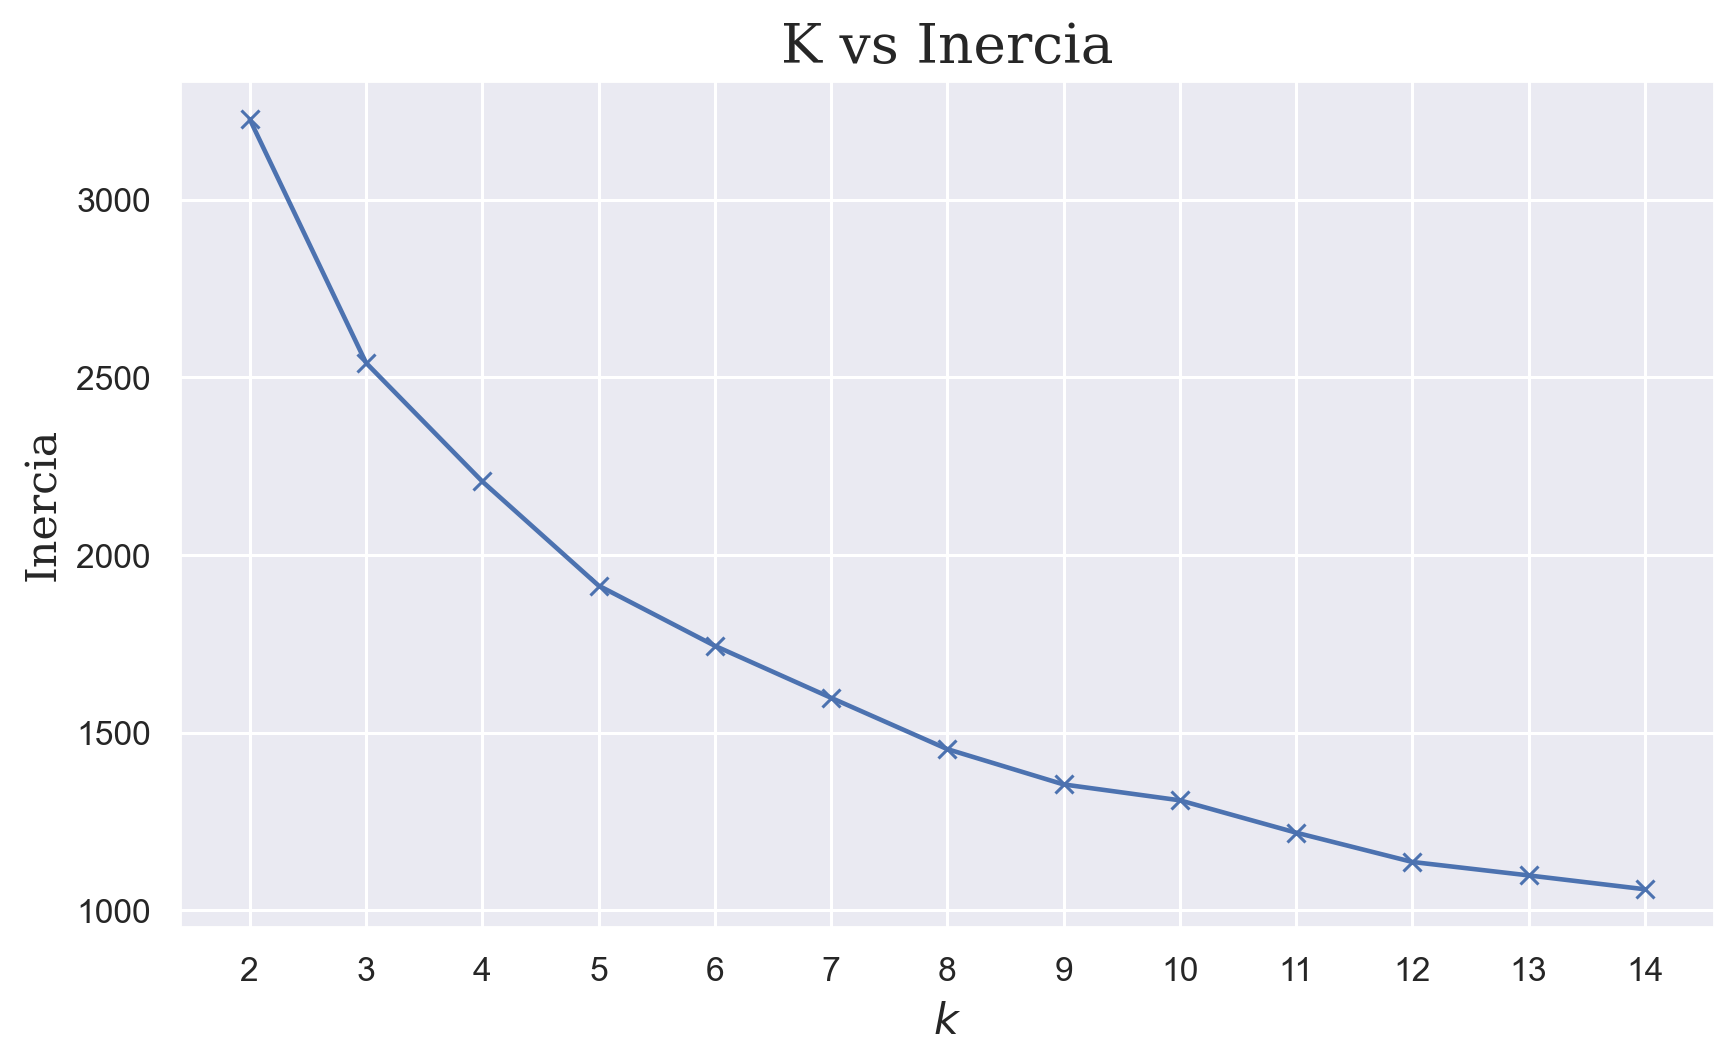

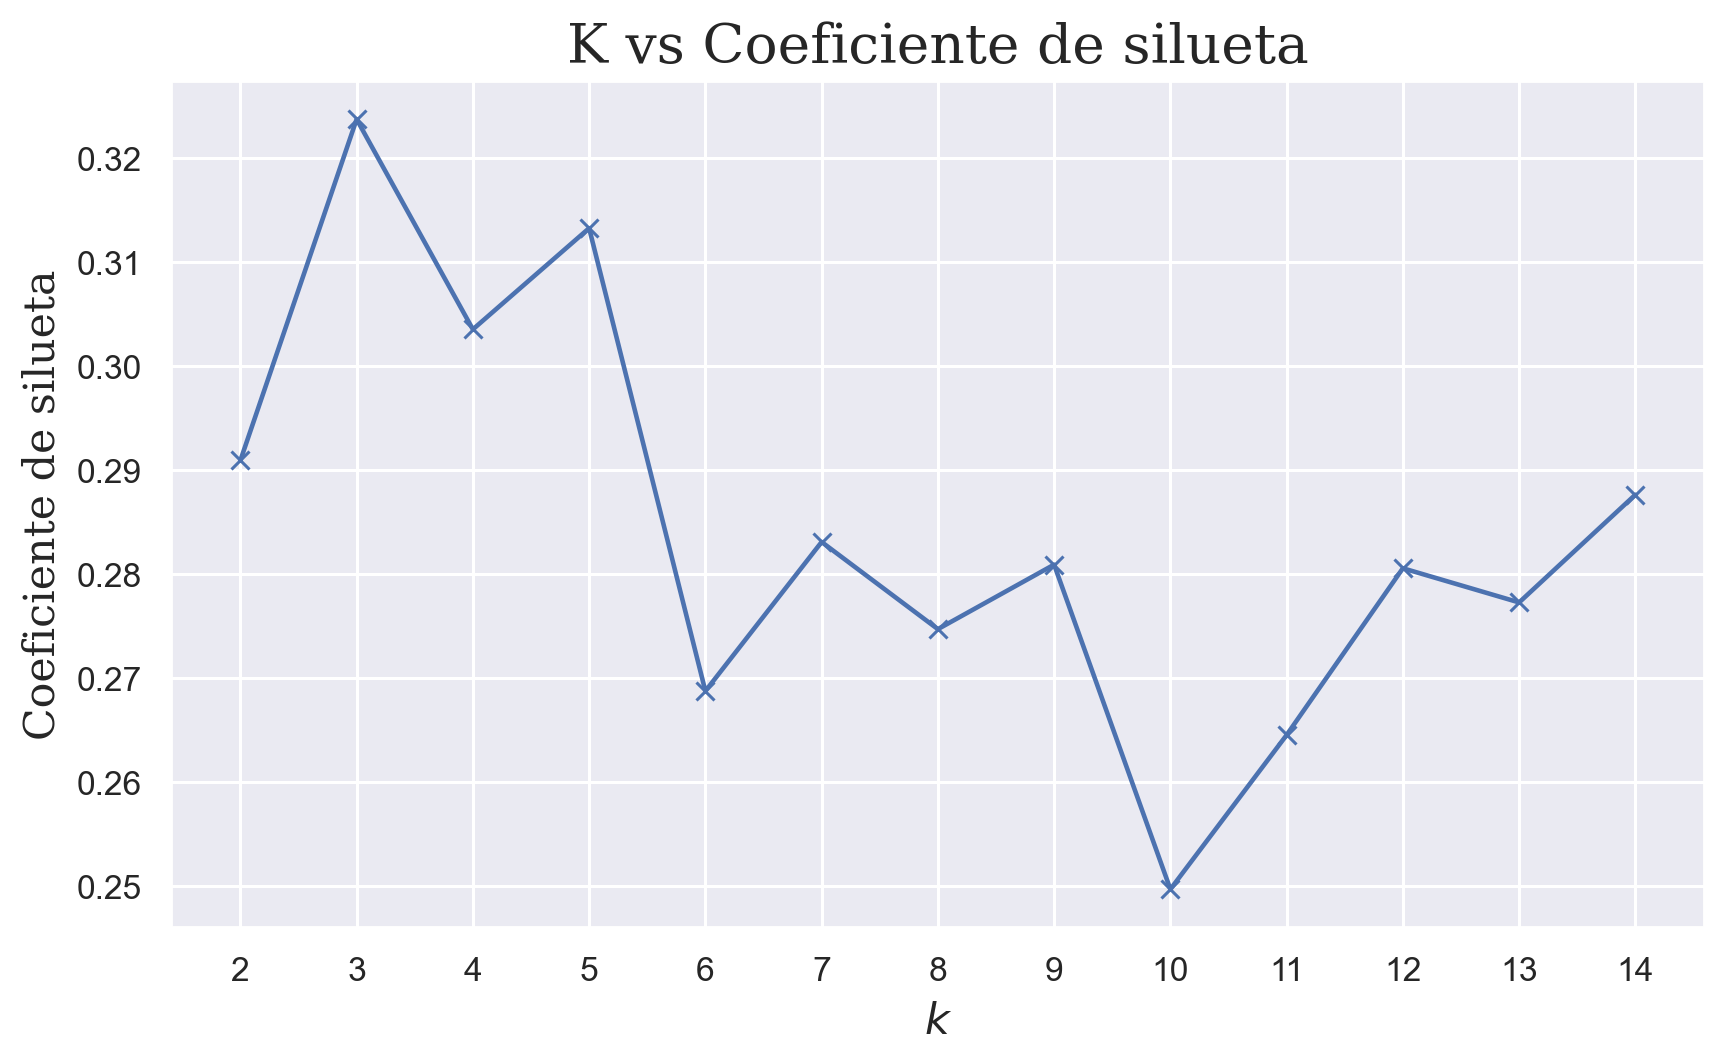

In [57]:
inertia = []
silhouette = []
K = range(2, 15)
for i in K:
  # Declaramos y ejecutamos el algoritmo K-means.
  model = KMeans(n_clusters=i)
  model.fit(X_preprocessed)

  # Predecimos las etiquetas de X_preprocessed.
  y = model.predict(X_preprocessed)

  # Almacenamos la métrica de inercia y el coeficiente de silueta.
  inertia.append(model.inertia_)
  silhouette.append(silhouette_score(X_preprocessed, y))


plot_metric(K, inertia, 'Inercia')
plot_metric(K, silhouette, 'Coeficiente de silueta')

A partir de la evaluación del desempeño interno, podríamos concluir que un buen número para $k$ es 3, el valor que maximiza el coeficiente de silueta.

### **5.3.2. Evaluación del desempeño externa (supervisada)**
---
Graficamos la homogeneidad:

In [58]:
plot_extern_metric(X_preprocessed, y_titanic, homogeneity_score, 'Homogeneidad')

NameError: name 'plot_extern_metric' is not defined

Graficamos la información mutua:

In [59]:
plot_extern_metric(X_preprocessed, y_titanic, mutual_info_score, 'Información mutua')

NameError: name 'plot_extern_metric' is not defined

Graficamos el índice de *Rand*:

In [60]:
plot_extern_metric(X_preprocessed, y_titanic, adjusted_rand_score, 'Índice de Rand')

NameError: name 'plot_extern_metric' is not defined

A diferencia de la evaluación del desempeño interna, la externa nos sugiere usar un valor de $k$ más grande.

En este caso podríamos concluir que un buen valor para $k$ es $6$, el valor que maximiza el índice ajustado de _Rand_. Recuerde que el índice de _Rand_ es una medida de similitud entre los dos agrupamientos.

Cabe aclarar que, la selección de $k$ depende del objetivo de análisis, si este tiene que ver con la supervivencia es mejor quedarse con $k=6$ sugerido por los métodos de evaluación externa.

## **5.4. Interpretación de los centroides**
---

Para la interpretación de los centroides obtenidos en el proceso vamos a examinar los valores de los centroides encontrados por **`KMeans`** para conocer el prototipo de cada grupo. Si tomáramos el atributo **`cluster_centers`** sin más obtendríamos datos numéricos estandarizados, los cuales serían díficiles de interpretar.

Para esto, definimos las funciones **`show_survival_ratios`**, que imprime la proporción de personas que sobrevivieron de cada grupo encontrado por **`KMeans`** y la función **`show_centroids`** que aplica la transformación inversa a la estandarización (**`scaler.inverse_transform`**) a las características numéricas de cada centroide, recolecta cada centroide en una lista y los retorna cómo un _DataFrame_ con las columnas correspondientes para facilitar la lectura.

No se aplica una transformación inversa al _One Hot Encoding_, pues no estaría bien definido si los valores son distintos de $0$ y $1$. Los valores de un centroide del _One Hot Encoding_ se pueden interpretar como porcentajes de presencia de cada valor en un grupo.

En cada función se redondean los valores a $5$ decimales para facilitar la lectura. Lea las implementaciónes con detenimiento:

In [61]:
def show_survival_ratios(X, y, k):
  # Se entrena KMeans con k grupos y random_state fijo para obtener resultados reproducibles.
  model = KMeans(n_clusters=k, random_state=32)
  model.fit(X_preprocessed)

  # Obtenemos las etiquetas de grupo del modelo.
  y_pred = model.predict(X)

  for i in range(k):
    # Ejemplos que pertenecen al i-esimo grupo.
    ids_group = y_pred == i

    # Etiquetas reales de los ejemplos del grupo.
    labels_group = y[ids_group]

    # Calculamos la proporción como la media, pues consiste en valores con 0 y 1.
    survival_ratio = np.round(np.mean(labels_group), 5)
    print(f'Proporción de supervivencia grupo {i}: {survival_ratio}')

In [62]:
def show_centroids(X, k, tf):
  # Se entrena KMeans con k grupos y random_state fijo para obtener resultados reproducibles.
  model = KMeans(n_clusters=k, random_state=32)
  model.fit(X_preprocessed)

  # Guardamos scaler para usar la transformación inversa después.
  scaler = tf.named_transformers_['scaler']

  # Inicializamos una lista de los centroides vacía.
  centroids = []

  # Iteramos por cada centroide (con estandarización)

  for centroid in model.cluster_centers_:
    # Creamos una copia del centroide, en otro caso podríamos sobrescribir los valores obtenidos en el entrenamiento.
    centroid_copy = centroid.copy()
    # Se aplica la transformación inversa a las características numéricas.
    centroid_copy[5:] = scaler.inverse_transform([centroid_copy[5:]])
    # Redondeamos y almacenamos el centroide.
    centroids.append(np.round(centroid_copy, 5))

  # Definimos una lista con los nombres de las columnas correspondientes.
  columns = ['C', 'Q', 'S', 'female', 'male', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

  # retornamos un DataFrame
  return pd.DataFrame(centroids, columns=columns)

Debido a los resultados de la evaluación del desempeño externa e interna, que indican que $3$ y $6$ son valores apropiados para $k$, mostramos los centroides para estas dos configuraciones:

Visualizamos la matriz de contingencia junto con las funciones que se acaban de definir para $k=3$:

In [63]:
show_contigency_matrix(X_preprocessed, y_titanic, 3, ['Survived: False', 'Survived: True'])

NameError: name 'show_contigency_matrix' is not defined

In [64]:
show_survival_ratios(X_preprocessed, y_titanic, 3)
show_centroids(X_preprocessed, 3, tf)

Proporción de supervivencia grupo 0: 0.27059
Proporción de supervivencia grupo 1: 0.53333
Proporción de supervivencia grupo 2: 0.64286


,C,Q,S,female,male,Pclass,SibSp,Parch,Fare,Age
0,0.10588,0.04941,0.84471,0.27529,0.72471,2.68706,0.22588,0.10588,12.80875,29.04922
1,0.10476,0.04762,0.84762,0.57143,0.42857,2.51429,1.83810,1.89524,39.31714,14.47381
2,0.40659,0.01099,0.58242,0.45055,0.54945,1.03846,0.42308,0.35165,82.63661,39.77747


Podemos darnos cuenta de que los centroides muestran el valor medio de cada característica para las personas a el grupo.

En el caso de las variables categóricas, los valores del centroide corresponden a las proporciones de personas con cada uno de los valores posibles.

Una observación que se puede realizar es sobre el grupo $1$, este tiene la menor proporción de supervivencia ($0.27059$) y podemos observar que la proporción de puerto de embarcamiento (**`Embarked`**) para el valor **`S`** (Southampton) corresponde al $0.84471$.

Es decir, una gran proporción de personas que embarcaron en *Southampton* no sobrevivieron.

Al igual que con $3$ grupos, visualizamos la matriz de contingencia junto con las funciones para $k=6$:

In [65]:
show_contigency_matrix(X_preprocessed, y_titanic, 6, ['Survived: False', 'Survived: True'])

NameError: name 'show_contigency_matrix' is not defined

In [66]:
show_survival_ratios(X_preprocessed, y_titanic, 6)
show_centroids(X_preprocessed, 6, tf)

Proporción de supervivencia grupo 0: 0.12364
Proporción de supervivencia grupo 1: 0.8
Proporción de supervivencia grupo 2: 0.55978
Proporción de supervivencia grupo 3: 0.65753
Proporción de supervivencia grupo 4: 0.63636
Proporción de supervivencia grupo 5: 0.125


,C,Q,S,female,male,Pclass,SibSp,Parch,Fare,Age
0,0.08727,0.03636,0.87636,0.00727,0.99273,2.78182,0.13818,0.02545,11.25416,29.22727
1,0.55000,0.00000,0.45000,0.70000,0.30000,1.00000,0.80000,1.20000,273.33001,31.85000
2,0.34239,0.01630,0.64130,0.39130,0.60870,1.18478,0.39674,0.16304,54.54472,42.30435
3,0.15753,0.06849,0.77397,0.82877,0.17123,2.57534,0.59589,0.38356,16.54932,21.25288
4,0.16364,0.01818,0.81818,0.69091,0.30909,2.20000,0.54545,2.54545,46.21561,23.95909
5,0.00000,0.12500,0.87500,0.37500,0.62500,2.96875,3.81250,1.59375,33.00312,7.06250


Podemos observar, por ejemplo, el grupo $0$. Es el grupo con mayor proporción de supervivencia ($0.78125$). La mayoría de las personas de este grupo son mujeres, todos corresponden a pasajeros de primera clase y el valor promedio que pagaron por su tickete es el más elevado ($222.03463$) de todos los grupos.

# **Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de la librería *Scikit-learn* en el desarrollo y evaluación de modelos de aprendizaje no supervisado como el agrupamiento, además de material de apoyo teórico para reforzar estos conceptos:

- [Clustering - Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html)
- [Hierarchial Clustering - Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)
- [Column Transformer for heterogeneous data - Scikit-learn ](https://scikit-learn.org/stable/modules/compose.html#column-transformer)
- [Data Mining Cluster Analysis: Basic Concepts and Algorithms - Introduction to Data Mining by Tan, Steinbach, Karpatne, Kumar](https://www-users.cs.umn.edu/~kumar001/dmbook/slides/chap7_basic_cluster_analysis.pdf)
- [Cluster Analysis in Data Mining](https://es.coursera.org/learn/cluster-analysis)






## **Referencias**
---
- Manning, C., Raghavan, D. & Schütze, H. (2008). Introduction to Information Retrieval [Introducción a la recuperación de información].

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:**
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*